In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_prior
import seis_nn
#plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
# %%time
# import seis_test
# seis_test.run_all_tests(test_reference_mode=True)


Importing cache: 100%|█████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6249.66it/s]


28.76165151233673 2828.2564022853535
(4900, 200)


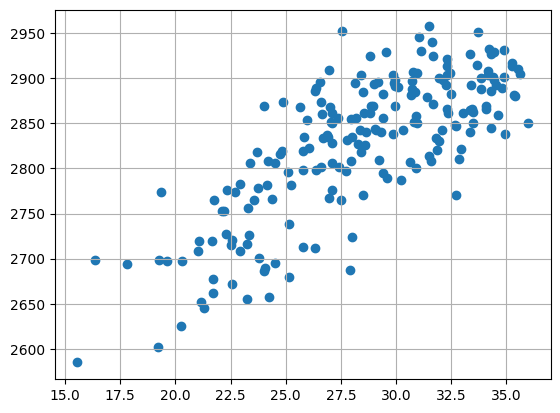

In [3]:
import cupy as cp
from scipy import stats
plt.figure()
slopes = []
intercepts = []
yy =[]
data = kgs.load_all_train_data()[9000:9200]
data = seis_nn.default_pretrained.infer(data)
for d in data:
    #d = kgs.load_all_train_data()[8011]   
    d.load_to_memory()
    #y = d.velocity.to_vector()
    #plt.plot(cp.asnumpy(cp.mean(d.velocity.data,axis=1)))
    x = np.arange(-35,35)
    y = cp.asnumpy(cp.mean(d.velocity.data,axis=1))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    slopes.append(slope)
    intercepts.append(intercept)

    d.velocity_guess.to_cupy()
    yy.append(d.velocity.to_vector()[:-1,:]-d.velocity_guess.to_vector()[:-1,:])
    
    # def cov(hyp):
    #     sigma_noise = hyp[0]
    #     sigma_mean = hyp[1]
    #     sigma_
plt.scatter(slopes,intercepts)
plt.grid(True)
slopes = np.array(slopes);intercepts=np.array(intercepts);
full_y = cp.stack(yy)[:,:,0].T
#y = y[:,0:1]
#y = y-cp.mean(y)
print(kgs.rms(slopes), kgs.rms(intercepts))
print(full_y.shape)


In [4]:
def negative_log_likelihood(hyp_np: np.ndarray) -> float:
    """
    Compute the negative log marginal likelihood for N independent outputs,
    each of dimension n = 4901, under a zero-mean Gaussian with covariance K = cov(hyp).
    y has shape (n, N).  This operates on the GPU (CuPy) except for returning
    a Python float at the end.
    """
    #print(np.exp(hyp_np))
    #print(hyp_np[2])
    # 1) Convert hyp from NumPy to CuPy:
    #hyp_gpu = cp.asarray(hyp_np, dtype=cp.float64)

    # 2) Build the n×n covariance matrix on the GPU:
    K = cov(hyp_np)  # shape (n, n), dtype=float64
    #K = np.exp(hyp_np[0])**2 * cp.eye(4900)

    # 3) Add jitter on the diagonal for numerical stability:
    n, N = y.shape  # n should be 4901, N is the number of columns
    K.flat[0 : n * n : n + 1] += _jitter  # equivalent to K += jitter * I


    # 4) Compute the Cholesky decomposition: K = L L^T
    #    (CuPy’s Cholesky runs on the GPU)
    L = cp.linalg.cholesky(K)  # shape (n, n)

    # 5) Solve for A = K^{-1} Y by two triangular solves:
    #      L V = Y   →   V = L^{-1} Y   (shape (n, N))
    #      L^T A = V →   A = (L^T)^{-1} V   (shape (n, N))
    V = cp.linalg.solve(L, y)       # solve L V = y
    A = cp.linalg.solve(L.T, V)     # solve L^T A = V

    # 6) Compute the log-determinant of K:
    #      log |K| = 2 * sum(log(diag(L)))
    diag_L = cp.diag(L)             # shape (n,)
    logdet_K = 2.0 * cp.sum(cp.log(diag_L))


    # 7) Compute the data‐fit term:
    #      sum_i y_i^T K^{-1} y_i = trace(Y^T A) = sum(Y * A)
    data_fit_term = 0.5 * cp.sum(y * A).item()  # scalar

    # 8) Complexity term: N/2 * log |K|
    complexity_term = 0.5 * N * logdet_K.item()

    # 9) Constant term: N * (n/2) * log(2π)
    const_term = 0.5 * N * n * np.log(2.0 * np.pi)

    # 10) Negative log‐likelihood:
    nll_value = data_fit_term + complexity_term + const_term
    return float(nll_value)


# ---------------------------------------------------------------------------
# CHOOSE AN INITIAL GUESS FOR hyp:
#
# If hyp has dimension d_hyp, set an initial log‐space guess, for example:
#     hyp0 = np.zeros(d_hyp, dtype=np.float64)
# Adjust d_hyp to match your model’s hyperparameter count.
# ---------------------------------------------------------------------------


In [5]:
importlib.reload(seis_prior)
def cov(hyp):
    prior = seis_prior.SquaredExponential()   
    prior.noise = np.exp(hyp[0])
    prior.sigma = np.exp(hyp[1])
    prior.length_scale = hyp[2]
    prior.sigma_slope = np.exp(hyp[3])
    prior.sigma_mean = np.exp(hyp[4])
    prior.compute_P=False
    prior.basis_functions()    
    return prior.K
hyp0 = np.log(np.array([100., 1000., 10., 3000., 30.]))



import cupy as cp
import numpy as np
from scipy.optimize import minimize

In [6]:
_jitter = 0.

d_hyp = len(hyp0)  # Example: 5 hyperparameters; change as needed.

y=full_y
# Optionally, specify bounds for log(hyp_j):
bounds = [(0., 8.),(0.,8.),(0.5,30.),(0.,5.),(0.,10.)]

# ---------------------------------------------------------------------------
# RUN THE OPTIMIZER (e.g., L-BFGS-B without supplying gradients).
# This will call negative_log_likelihood(hyp) repeatedly.
# ---------------------------------------------------------------------------
result = minimize(
    fun=negative_log_likelihood,
    x0=hyp0,
    method="L-BFGS-B",
    bounds=bounds,
    options={"maxiter":20, "disp": True},
)

print(result)
print(result.x)

False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)


In [7]:
importlib.reload(seis_prior)
hyp = copy.deepcopy(result.x)
#hyp[3]=np.log(1000)
K= cov(hyp)
NN=10

False False
(4901, 4901)


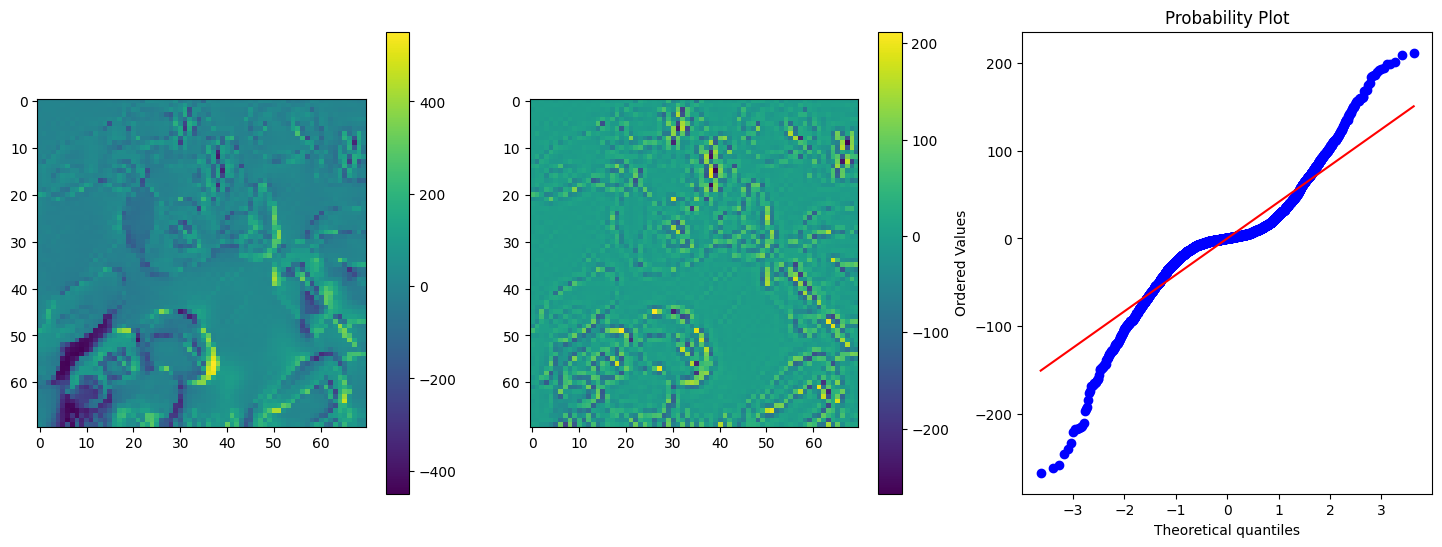

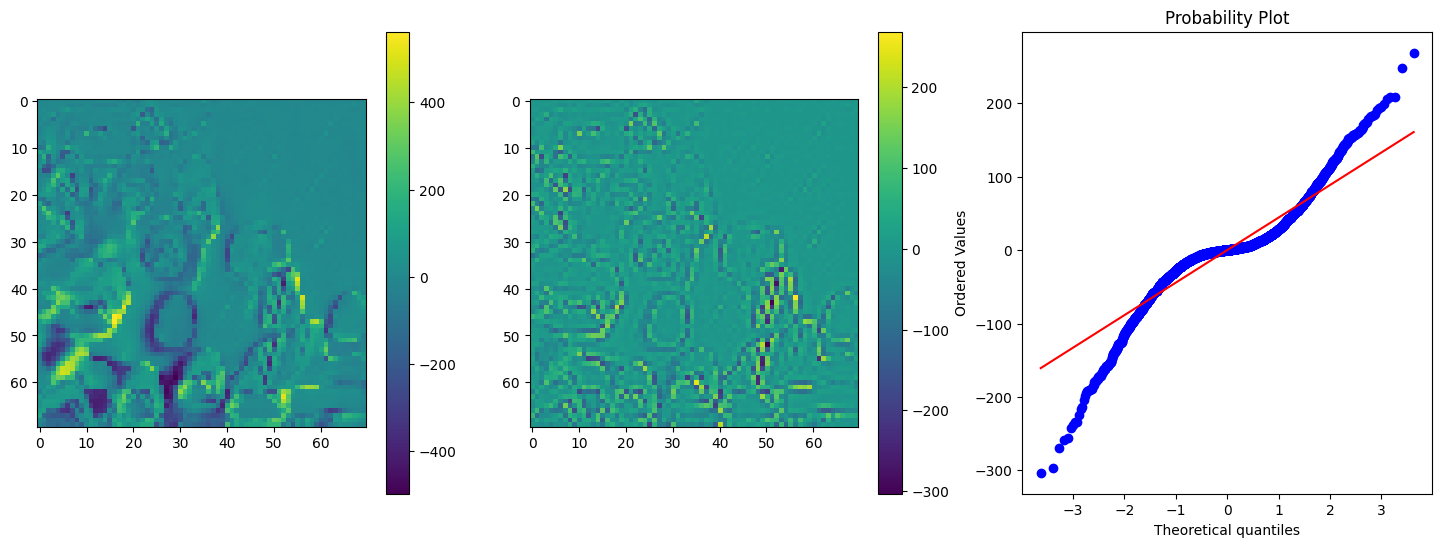

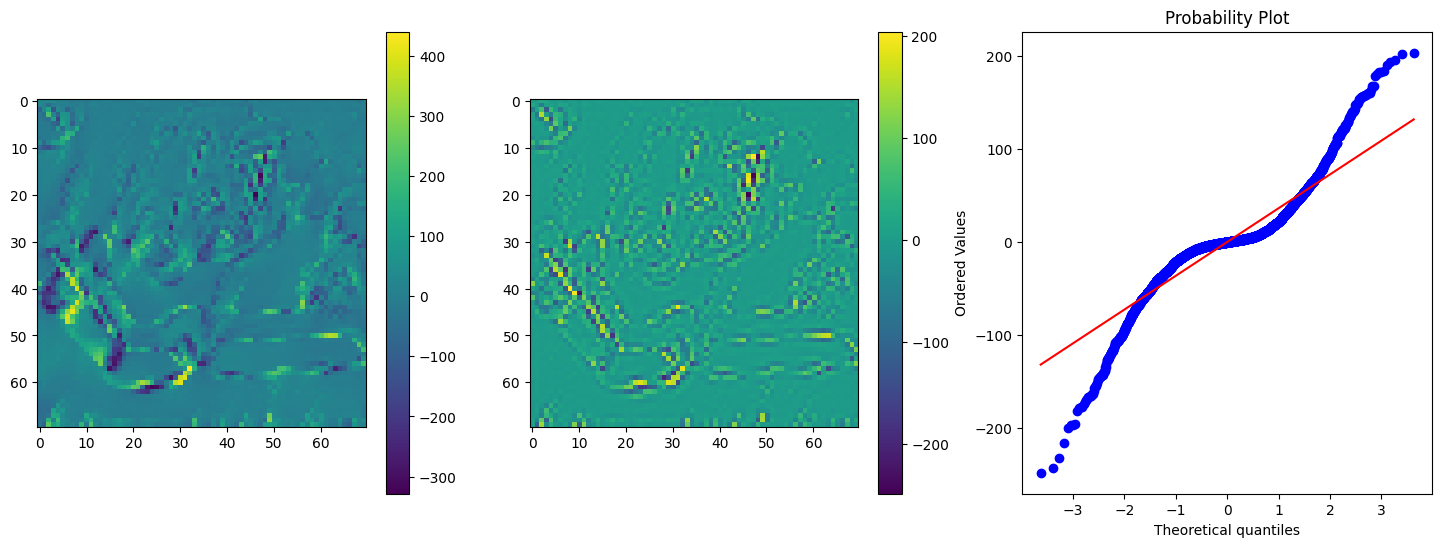

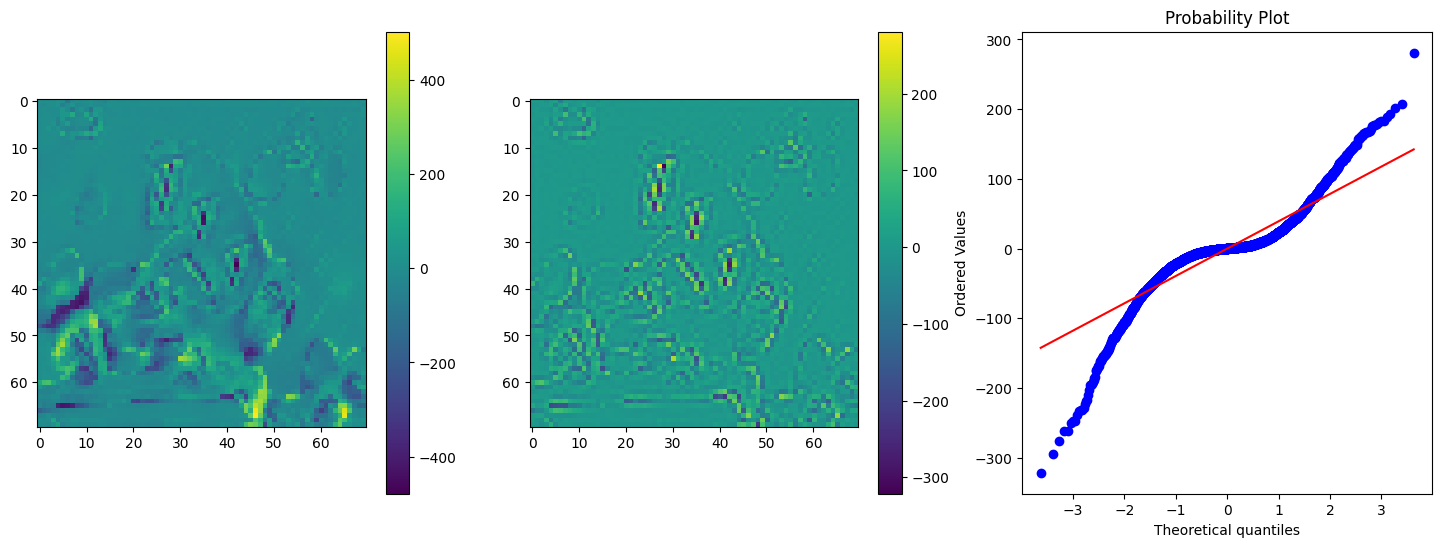

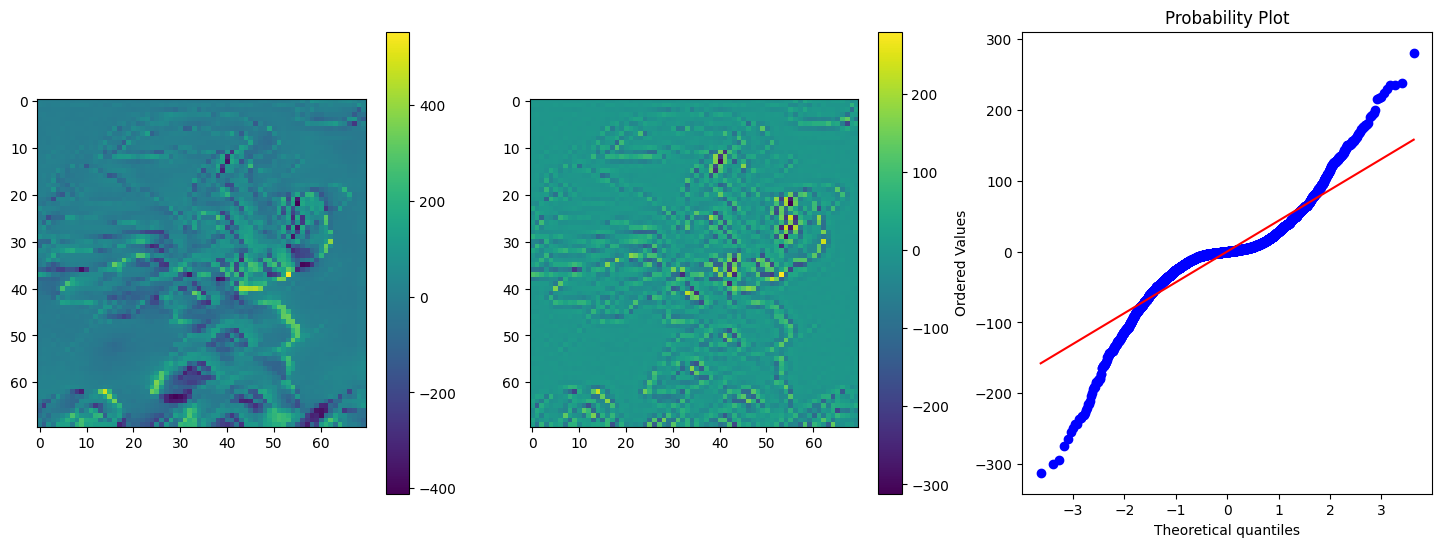

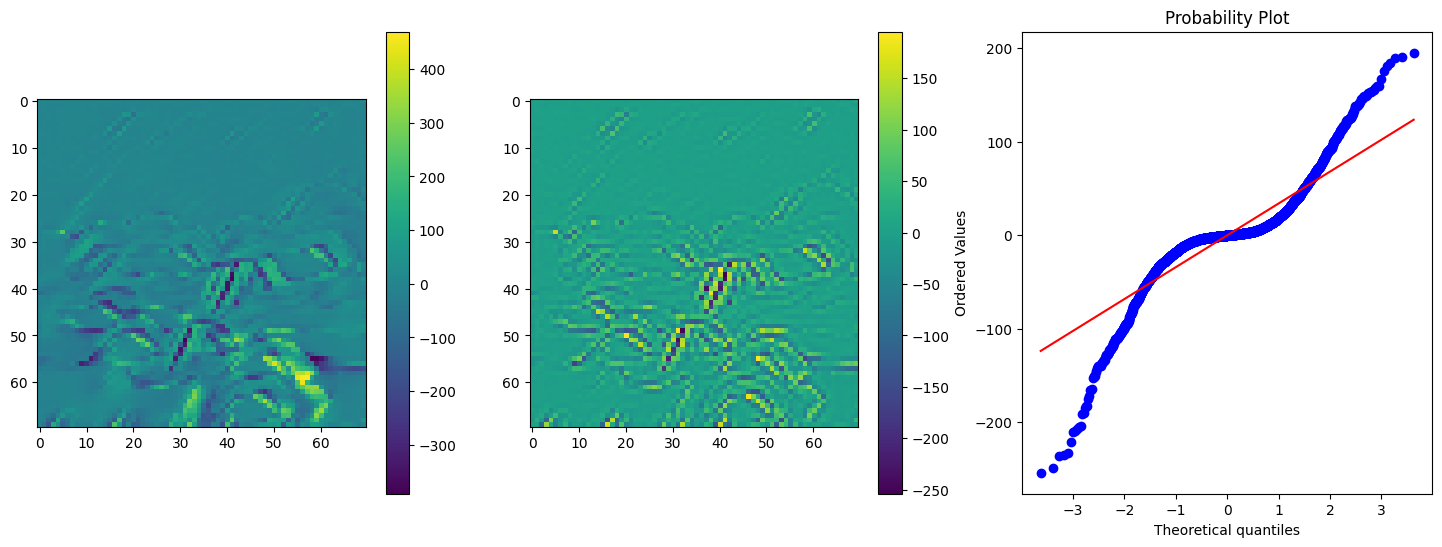

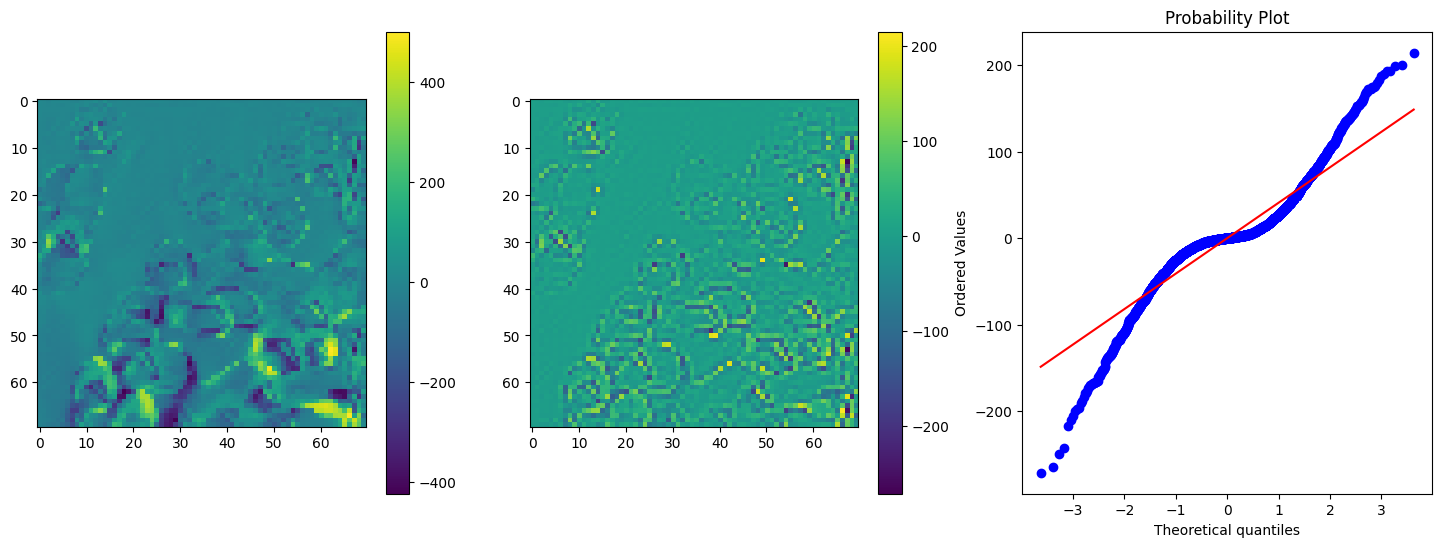

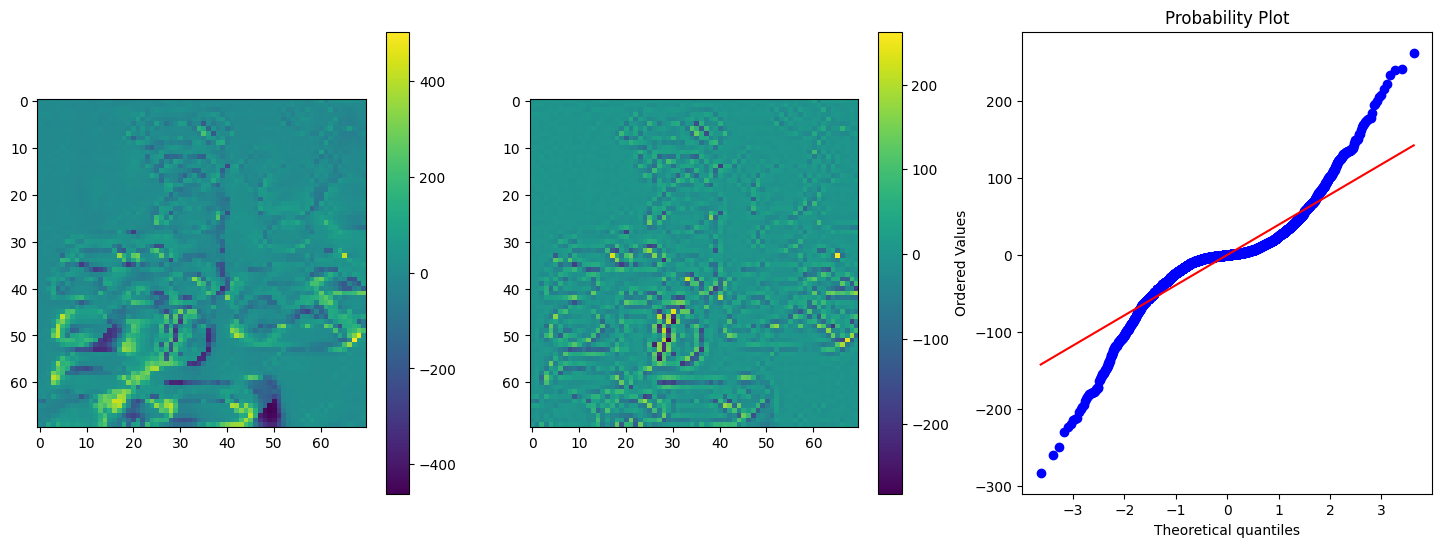

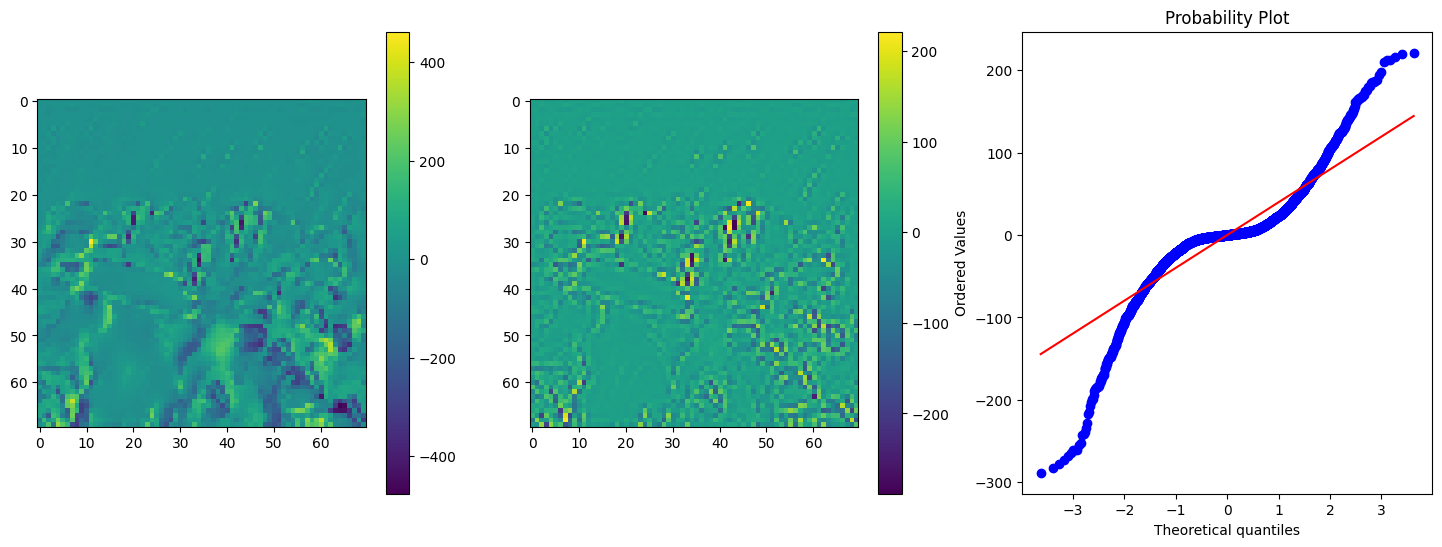

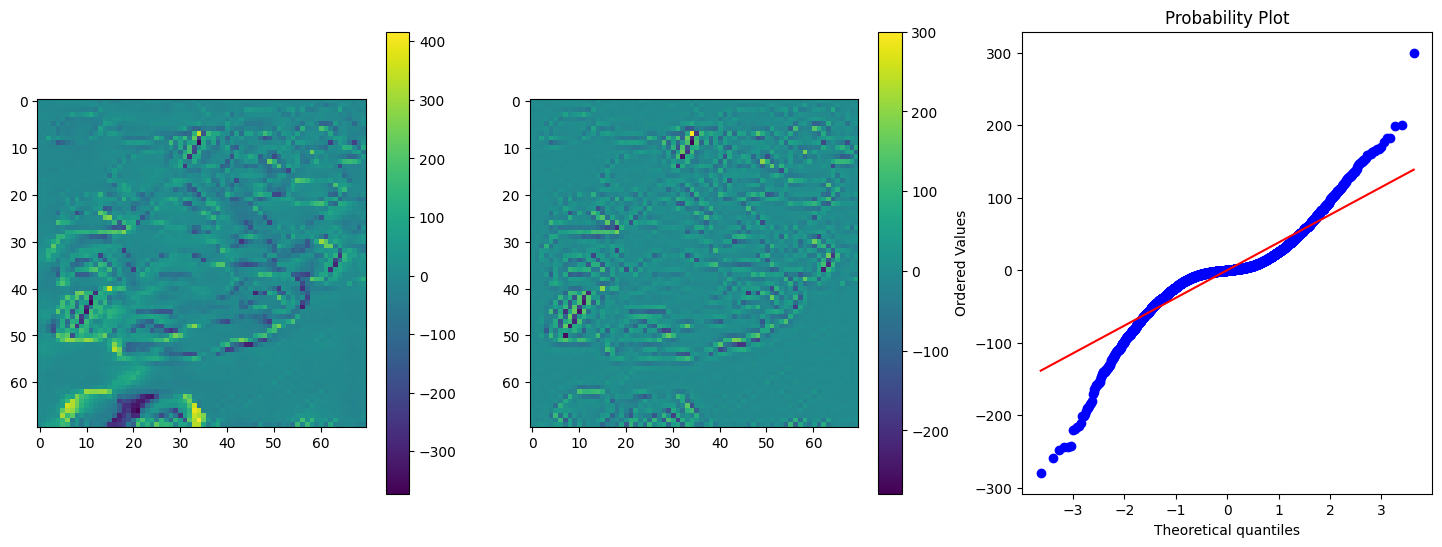

In [8]:
for ii in range(10):
    _,ax=plt.subplots(1,3,figsize=(18,6))
    noise_part = np.exp(hyp[0])**2*cp.linalg.solve(K,full_y[:,ii])
    plt.sca(ax[0])
    plt.imshow(cp.asnumpy(cp.reshape(full_y[:,ii], (70,70))));plt.colorbar()    
    plt.sca(ax[1])
    plt.imshow(cp.asnumpy(cp.reshape(noise_part, (70,70))));plt.colorbar()
    plt.sca(ax[2])
    #plt.imshow(cp.asnumpy(cp.reshape(full_y[:,ii]-noise_part, (70,70))));plt.colorbar()
    import scipy.stats
    scipy.stats.probplot(cp.asnumpy(noise_part),plot=plt)

In [9]:
samples = np.random.default_rng(seed=0).multivariate_normal(np.zeros(4900), cp.asnumpy(K), size=(NN))

In [10]:
# for ii in range(NN):
#     _,ax=plt.subplots(1,2,figsize=(12,6))
#     plt.sca(ax[0])
#     plt.imshow(np.reshape(samples[ii,:], (70,70)));plt.colorbar()
#     plt.sca(ax[1])
#     plt.imshow(cp.asnumpy(cp.reshape(y[:,ii], (70,70))));plt.colorbar()

False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)
False False
(4901, 4901)


Text(0, 0.5, 'length')

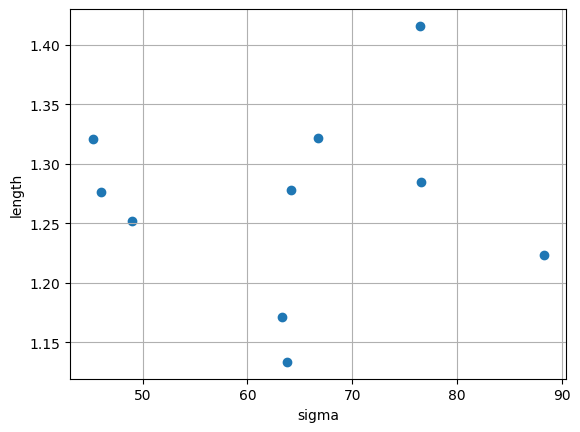

In [11]:
NN=10
sigma = []
length = []
for ii in range(NN):
    y = full_y[:,ii:ii+1]
    hyp0 = copy.deepcopy(result.x)
    # Optionally, specify bounds for log(hyp_j):
    bounds = [(x,x) for x in hyp0]
    bounds[1] = (0,8)
    bounds[2] = (0.5,30.)
    
    # ---------------------------------------------------------------------------
    # RUN THE OPTIMIZER (e.g., L-BFGS-B without supplying gradients).
    # This will call negative_log_likelihood(hyp) repeatedly.
    # ---------------------------------------------------------------------------
    result2 = minimize(
        fun=negative_log_likelihood,
        x0=hyp0,
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter":5, "disp": True},
    )

    sigma.append(np.exp(result2.x[1]))
    length.append(result2.x[2])
plt.figure()
plt.scatter(sigma,length)
plt.grid(True)
plt.xlabel('sigma')
plt.ylabel('length')